# Practical Lab2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

## Part 1

Setup environments

In [244]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from IPython.display import display
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from seaborn.axisgrid import JointGrid
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import plot_tree

# Setup environments
print(sns.__version__) 
%matplotlib inline
sns.set_style("whitegrid")

0.13.2


Functions defined in this report

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def MyPlot(_data: pd.DataFrame, _title: str, _xlabel: str):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size to fit both plots

    # Histogram with KDE
    sns.histplot(_data, kde=True, bins=50, color='blue', edgecolor='white', stat='density', ax=ax1)
    ax1.set_title(_title)
    ax1.set_xlabel(_xlabel)
    ax1.set_ylabel('Density')
    ax1.axvline(_data.mean(), color='red', linestyle='dashed', label=f"Mean: {_data.mean():.2f}")
    ax1.axvline(_data.median(), color='green', linestyle='dashed', label=f"Median: {_data.median():.2f}")
    ax1.legend()

    # Boxplot
    sns.boxplot(x=_data, showmeans=True, ax=ax2, vert=False)#, color='blue', )
    ax2.set_title(_title)
    ax2.set_xlabel(_xlabel)

    # Improve the layout to prevent overlap and ensure the plot is displayed correctly
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming 'labels_y' is your DataFrame or Series containing the data
# MyPlot(data=labels_y, title="Disease progression one year after baseline", xlabel="Disease progression")


### Framing the Problem
* This report tries to find aout which approach is better for predicting the risk of diabetes progression, that is formed as the disease progression one year after baseline. The following approaches will be selected and compared in this work: Univariate polynomial regression model, Multivariate Polynomial model, Decision Trees and KNN.
* All methods will be evaluated using R-squared, MAPE and MAE metrics over the training and testing results. 

### Getting the Data

Data Source: Downloaded from , [Diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), [load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes)

About the dataset:
* age: age in years
* sex: Gender of the patient (But it doesn't show that which number refers to male and female.)
* bmi: body mass index
* bp: average blood pressure
* s1: tc, total serum cholesterol
* s2: ldl, low-density lipoproteins
* s3: hdl, high-density lipoproteins
* s4: tch, total cholesterol / HDL
* s5 ltg, possibly log of serum triglycerides level
* s6 glu, blood sugar level

Load dataset

In [153]:
diabetes_X, labels_y = load_diabetes(
    return_X_y=True,
    as_frame=True,
    scaled=False # To get the raw data rather than after doing standardization.
)

### EDA  
Describe and explore our dataset. 

In [152]:
df_merged = diabetes_X.copy()
df_merged["labels"] = labels_y.copy()
print(f"Shapes: diabetes_X:{diabetes_X.shape}, labels_y:{labels_y.shape}, df_merged:{df_merged.shape}")
# df_merged["labels_norm"] = (df_merged.labels - df_merged.labels.mean()) / df_merged.labels.std()
df_merged.head()

Shapes: diabetes_X:(442, 10), labels_y:(442,), df_merged:(442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [7]:
df_merged.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


Run normalization with `Disease progression one year after baseline`

In [15]:
# Run normalization with labels "Disease progression one year after baseline"
df_merged["labels_norm"] = (df_merged.labels - df_merged.labels.mean()) / df_merged.labels.std()
df_merged.labels_norm.describe()

count    4.420000e+02
mean    -1.567374e-16
std      1.000000e+00
min     -1.649092e+00
25%     -8.448689e-01
50%     -1.509019e-01
75%      7.700636e-01
max      2.514710e+00
Name: labels_norm, dtype: float64

Draw histogram and Whisker plot with `Disease progression one year after baseline`.

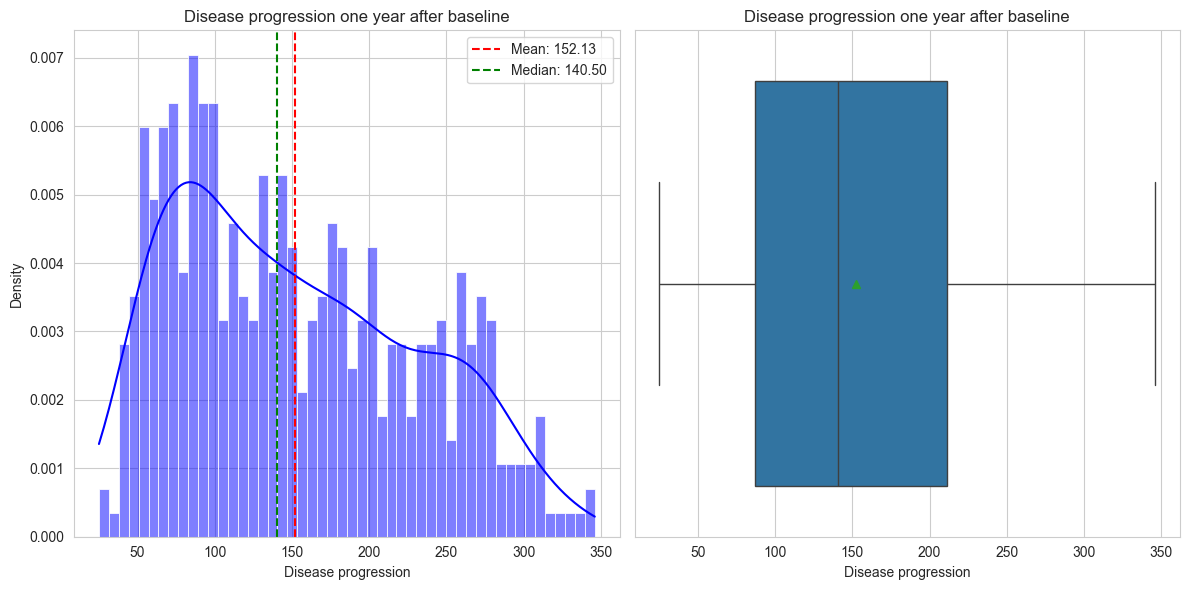

In [41]:
MyPlot(_data=labels_y, 
       _title="Disease progression one year after baseline", 
       _xlabel="Disease progression")

Observation:
* For all variables in diabeties, mean value is closed to median value.
* For the labels, mean (152.133484) is higher than median (140.500000), shows that the dataset might be right-skew distribution.
* After normalization, max label value becomes 2.514710 less than 3, so there might be no serious outliers.

Draw histogram for all variables

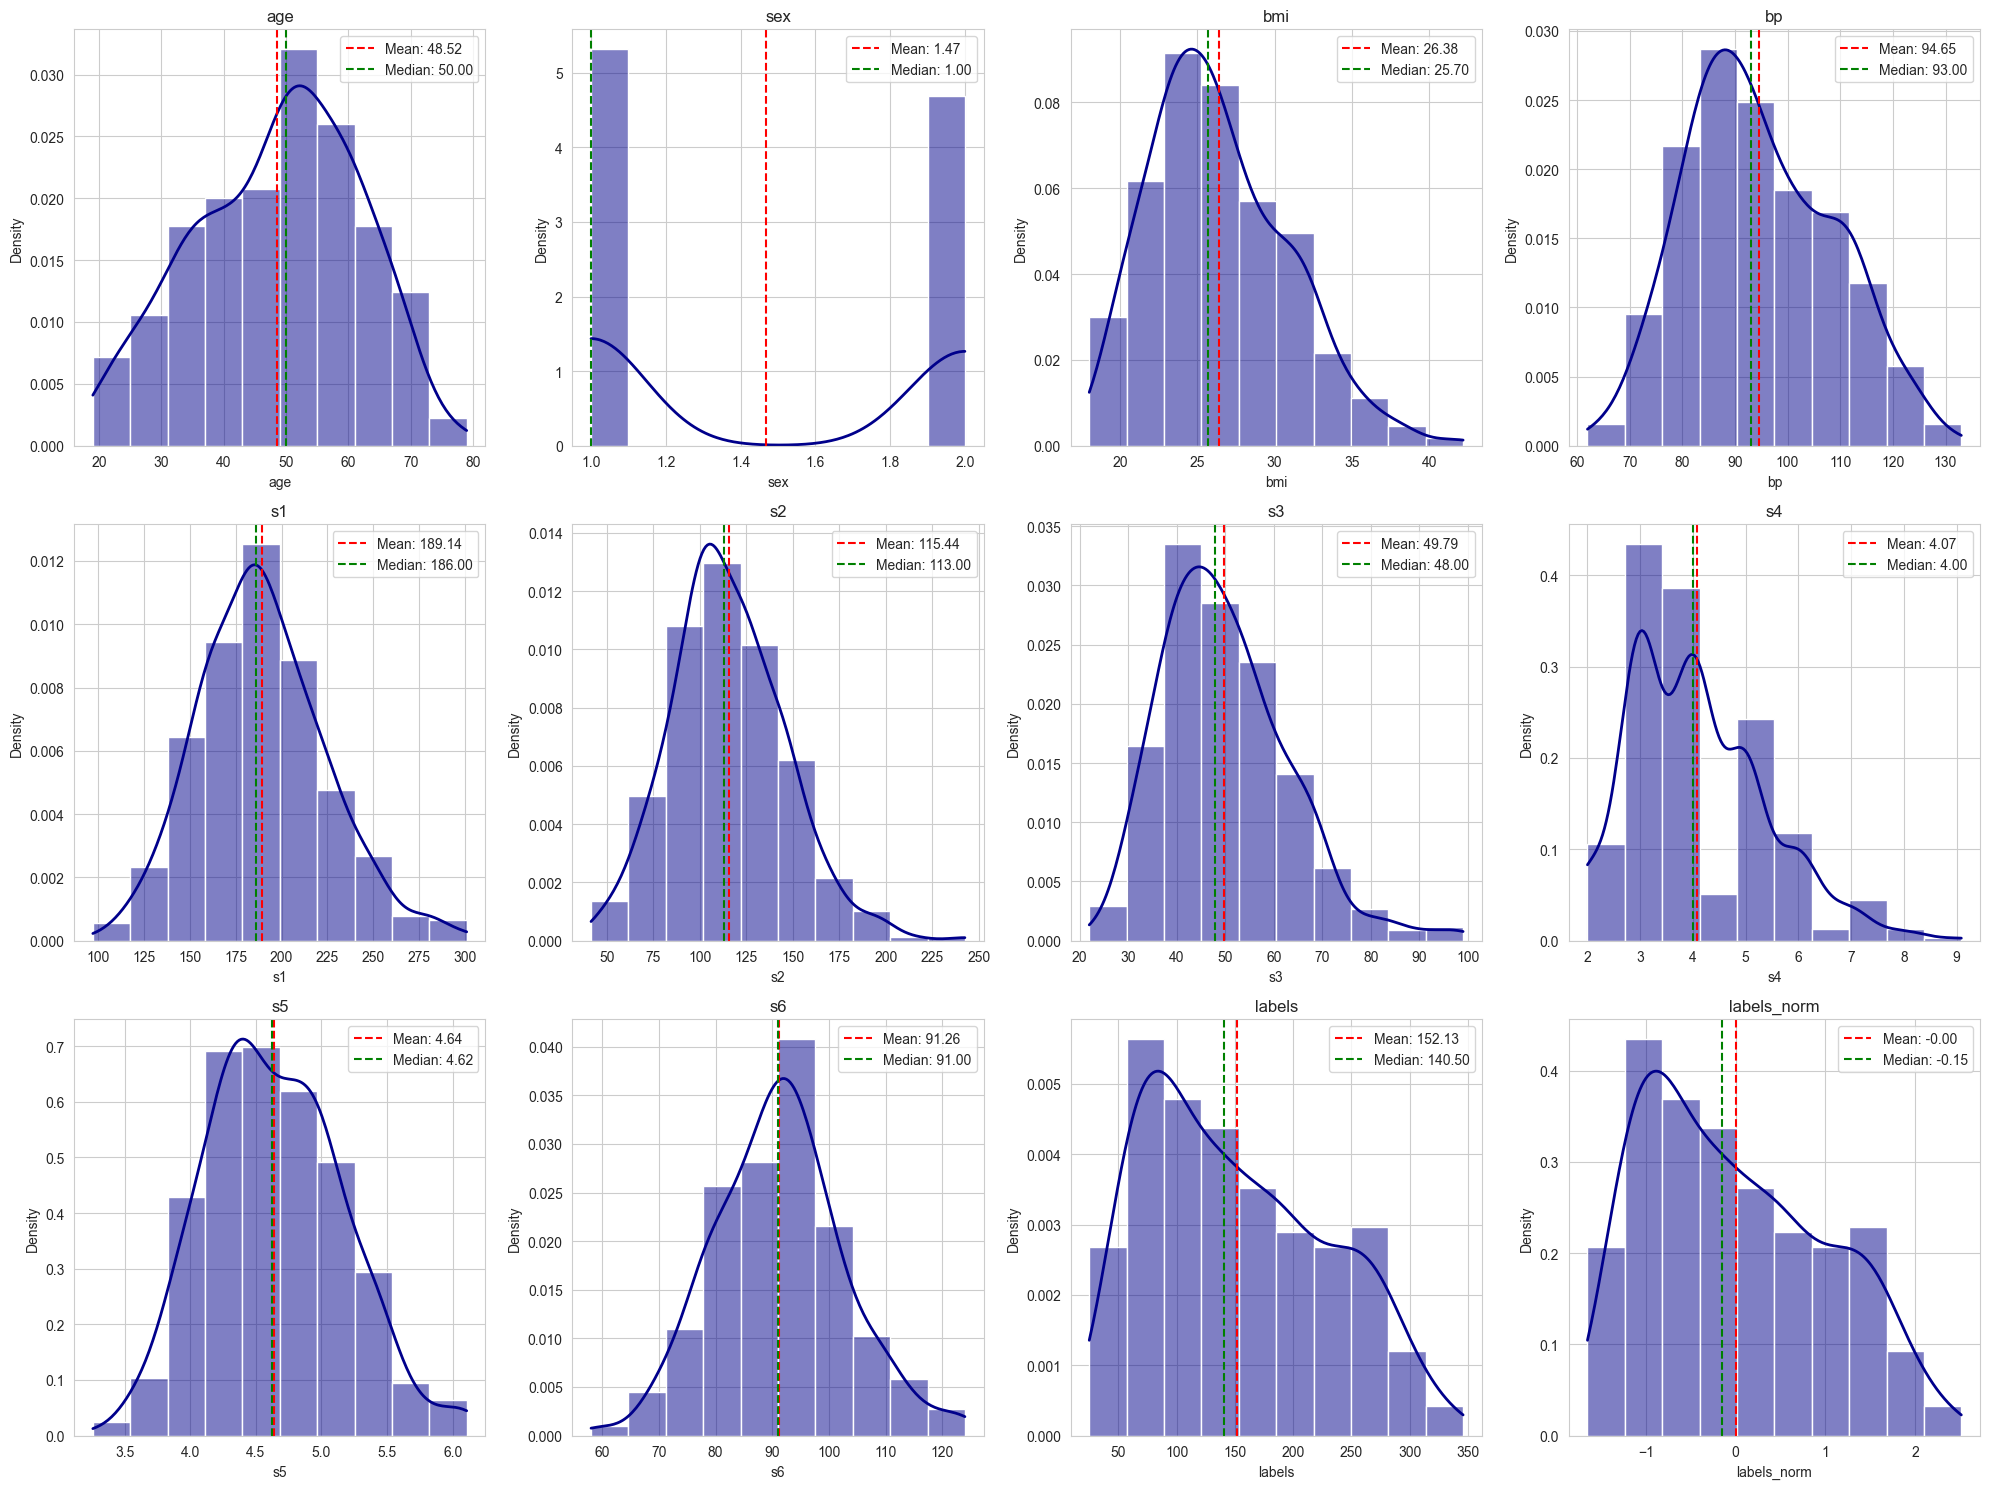

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()  # Flatten to 1D array for easier iteration

for i, col in enumerate(df_merged.columns):
    ax = axes[i]
    # Histogram with dark blue color and KDE with a contrasting light green color
    sns.histplot(df_merged[col], ax=ax, kde=True, bins=10, color='darkblue', edgecolor='white', stat='density', line_kws={'color': 'red', 'lw': 2})
    ax.set_title(col)
    ax.set_ylabel('Density')
    ax.axvline(df_merged[col].mean(), color='red', linestyle='dashed', label=f"Mean: {df_merged[col].mean():.2f}")
    ax.axvline(df_merged[col].median(), color='green', linestyle='dashed', label=f"Median: {df_merged[col].median():.2f}")
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


According to the histogram, most of the variables are distributed in a shape similar to normal distribution, such as s1, s2, s5, s6. Some shows a right skewed distribution, like s3, s4 and the label. 

Draw scatter plot for all independent variables

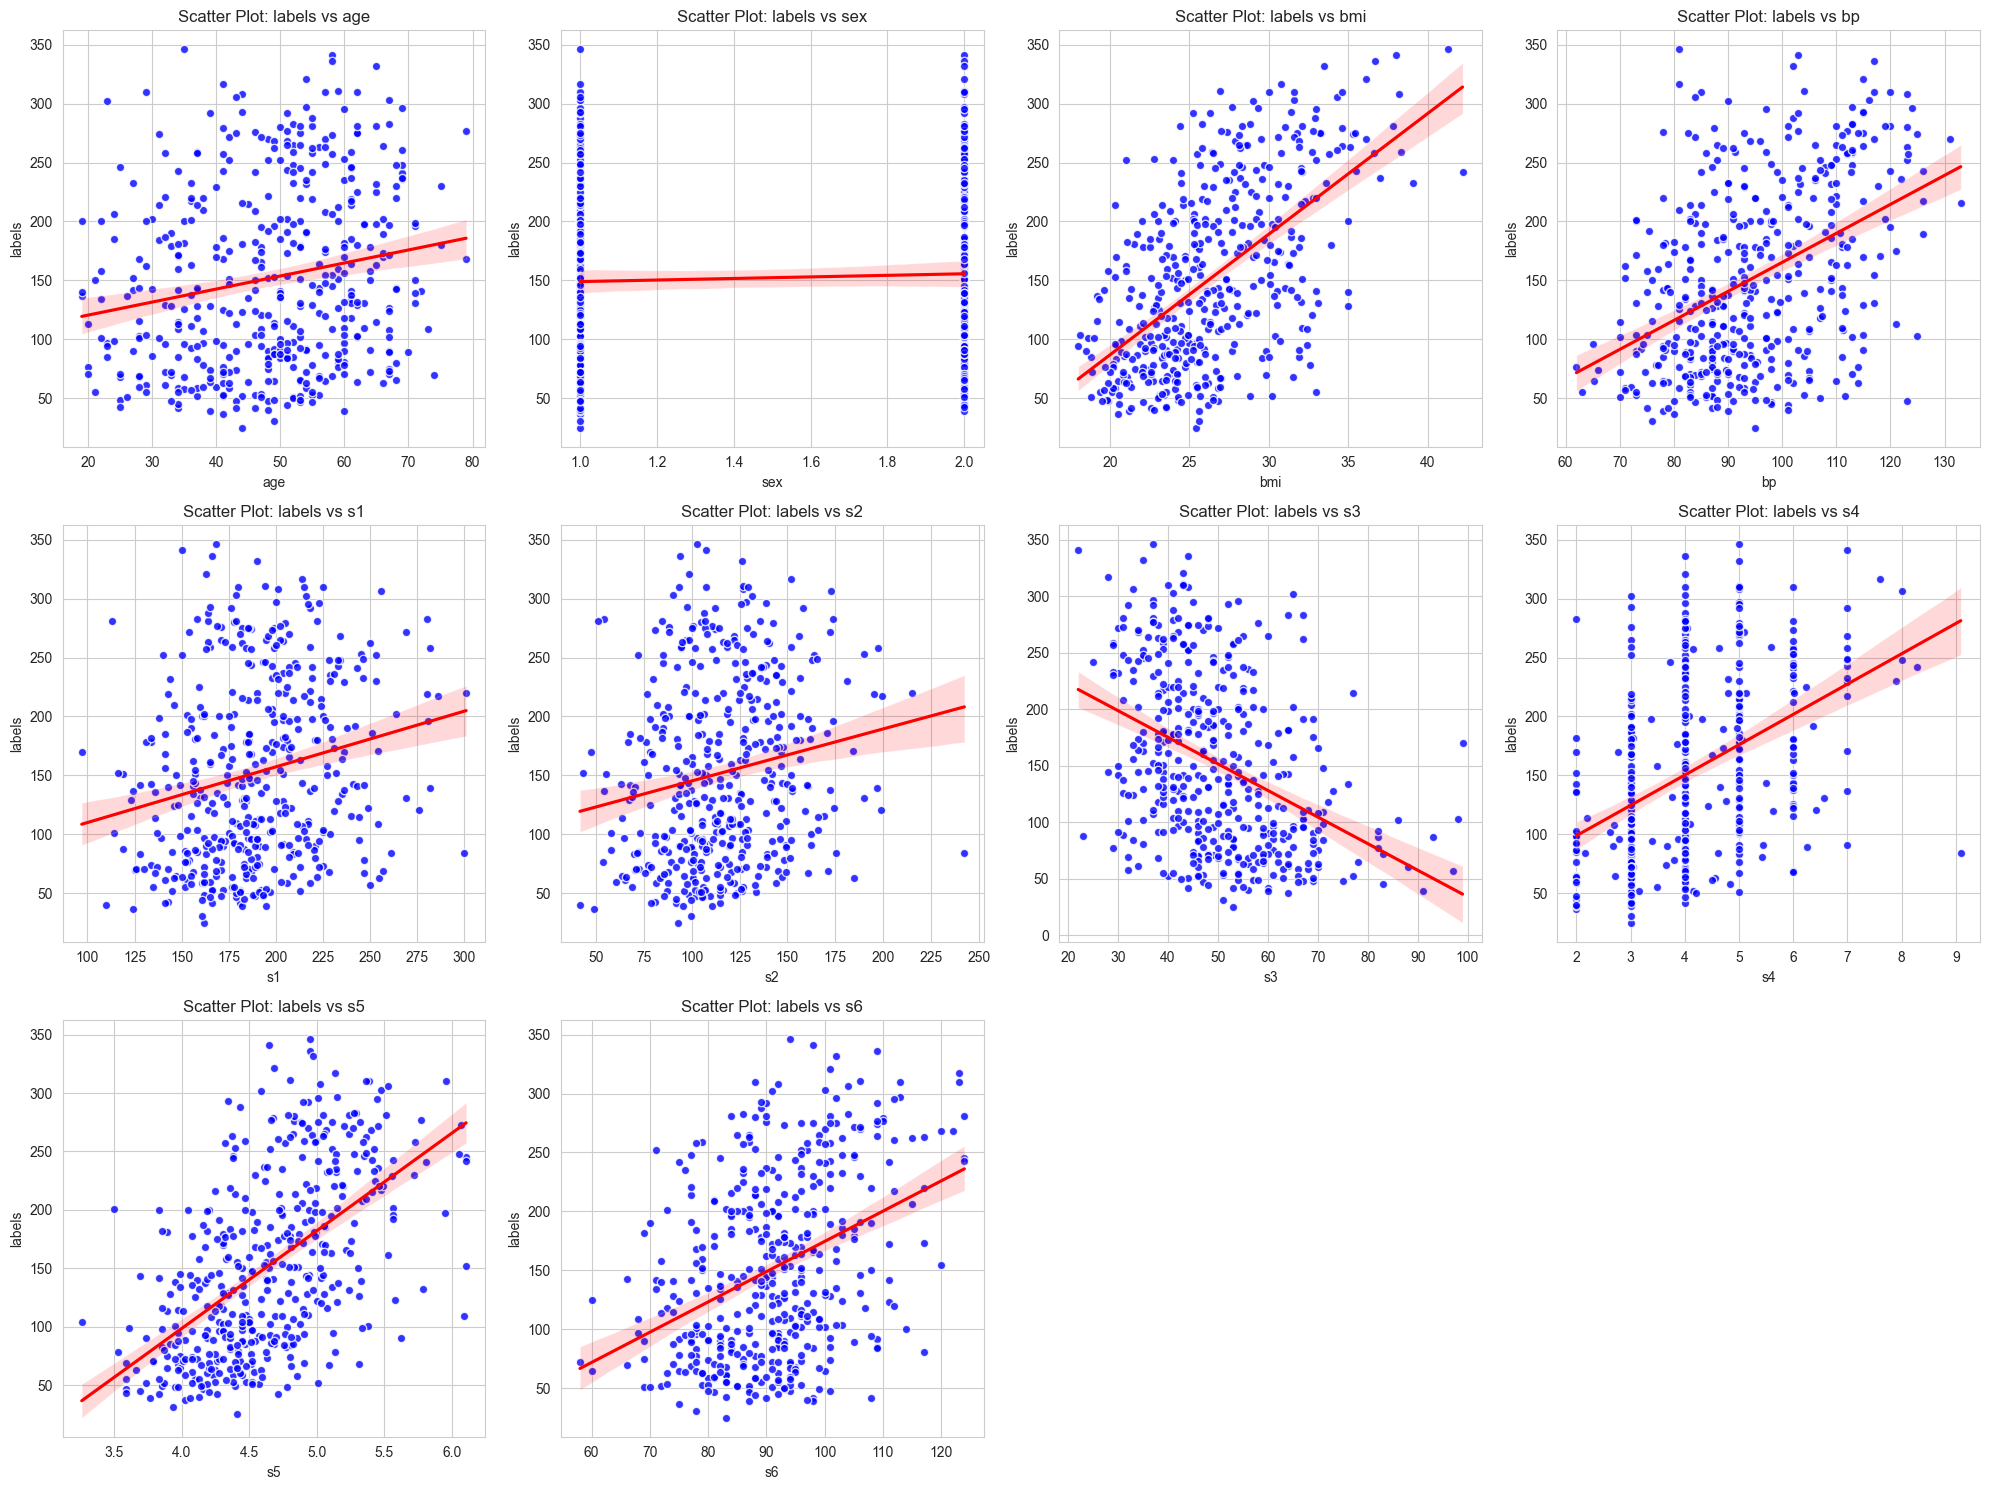

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_merged
dependent_var = 'labels'  # Replace with the name of your dependent variable
if "labels_norm" in df_merged.columns:
    df_merged.drop(columns="labels_norm", inplace=True)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()  # Flatten to 1D array for easier iteration

for i, col in enumerate(df.drop(columns=dependent_var)):  # Exclude the dependent variable from plotting
    ax = axes[i]
    # sns.scatterplot(data=df, x=col, y=dependent_var, ax=ax, color='blue', edgecolor='white')
    sns.regplot(data=df, x=col, y=dependent_var, ax=ax, color='blue', scatter_kws={'edgecolor':'white'}, line_kws={'color': 'red'})
    ax.set_title(f'Scatter Plot: {dependent_var} vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel(dependent_var)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Based on the observation of scatter plot and regplot, it shows that:  
1. These variables bmi, bp, s1, s2, ,s4, s5, and s6, shows a positive relationship with the dependent variable, which might be useful for training a regression model for prediction. 
2. However s3 shows a negitive relationship. 
3. There's no relation between the label and sex.

Corretation matrix

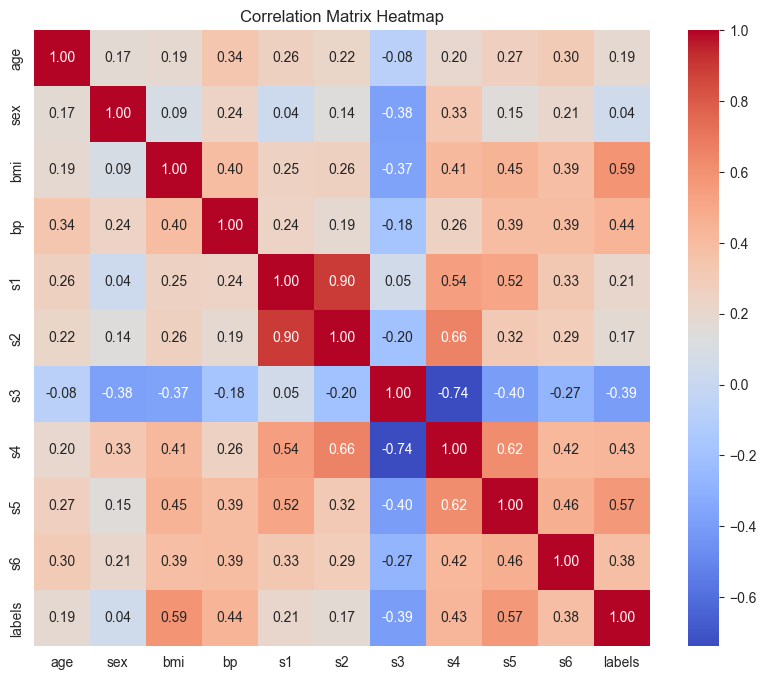

In [151]:
# Show corretation matrix
correlation_matrix = df_merged.corr()
# print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

Analysis of Variables Strongly Correlated with labels
* BMI: The correlation coefficient is 0.59, indicating a strong positive correlation between bmi and labels. This means that as bmi increases, the values of labels also tend to increase.
* BP: The correlation coefficient is 0.44, showing a positive correlation with labels. As blood pressure increases, the values of labels also tend to rise.
* s3: The correlation coefficient is -0.39, indicating a negative correlation with labels. An increase in s3 is associated with a decrease in the values of labels.

Check if there exists NaN in our dataset.

In [51]:
any_nan = df_merged.isna().any().any()
print(f"Is there any nan? {any_nan}")

total_nan = df_merged.isna().sum().sum()
print(f"Total number of NaN in DataFrame: {total_nan}")

Is there any nan? False
Total number of NaN in DataFrame: 0


Data cleaning  
Since, there are no outliers, and no nan values, we decide not to filt any values.

### Split into train/validation/test set  
* Based on the requirements, the dataset should be splited to a train (75%), validation set (10%), and test set (15%).

In [131]:
from sklearn.model_selection import train_test_split

X = df_merged.drop('labels', axis=1)
y = df_merged['labels']

# Select 75% for training set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

# Select 10% for validation set and 15% for testing set 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.4, random_state=42)

print(f"Shape of: Train:{X_train.shape}, Validation:{X_valid.shape}, Test:{X_test.shape}.")

Shape of: Train:(331, 10), Validation:(44, 10), Test:(67, 10).


## Part 2.

### Univariate polynomial regression

Run train and test with polynomial regression model by using `BMI featur`e versus `disease progression one year after baseline`, with different degree (0~5).

In [178]:
# Get bmi values from each set
selected_cols = ["bmi"]
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = [] # Store the evaluation results for each model
pipelines = [] # Store the models and polynomial featuers

# Train and test the six models (degree 0~5)
for degree in range(6):
    # Create a pipeline with poly and model
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])

    # Training
    pipeline.fit(_X_train, y_train)
    pipelines.append(pipeline)

    # Evaluate on training set
    y_train_pred = pipeline.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = pipeline.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)

    # Number of trainable parameters
    feature_names = pipeline['poly'].get_feature_names_out()#input_features=['BMI'])
    params_nums = len(feature_names)

    # Storing results
    results.append({
        'degree': degree,
        'R_squared_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R_squared_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va,
        'Num_of_params': params_nums
    })
    
# Display the result table
results_df = pd.DataFrame(results)
display(results_df)

# Choose the best model
best_model_index = np.argmax([r['R_squared_valid'] for r in results])  # Based on R-squared
best_model_degree = results[best_model_index]['degree']
print(f"The best model-degree is: {best_model_degree}")

# Print the best model's equation
best_pipiline = pipelines[best_model_index]
best_model = best_pipiline['model']
coefficients = best_model.coef_
intercept = best_model.intercept_
feature_names = best_pipiline['poly'].get_feature_names_out()
equation = " + ".join(f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names) if coeff != 0)
print(f"The equation of the best model is: y = {intercept:.4f} + {equation}")

# Evaluate the model with testing data
y_test_pred = best_pipiline.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


,degree,R_squared_train,MAE_train,MAPE_train,R_squared_valid,MAE_valid,MAPE_va,Num_of_params
0,0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880,1
1,1,0.349672,52.287739,48.362886,0.331264,47.208472,47.060009,2
2,2,0.350764,52.207314,48.298534,0.331631,47.213700,47.239667,3
3,3,0.350774,52.198968,48.280744,0.331638,47.185414,47.222673,4
4,4,0.353014,52.092653,48.053266,0.340758,46.090118,46.050330,5
5,5,0.354100,52.059191,48.004022,0.349881,45.462122,45.175276,6


The best model-degree is: 5
The equation of the best model is: y = 10409.7546 + -1809.2191*bmi + 123.5731*bmi^2 + -4.1234*bmi^3 + 0.0676*bmi^4 + -0.0004*bmi^5
Testing set evaluation is: R^2: 0.267, MAE: 51.75, MAPE: 43.03%


In [173]:
# For a given bmi value 30
bmi_value = 30
predicted_value = best_pipiline.predict(pd.DataFrame({'bmi': [bmi_value]}))
print(f"Predicted diabetes progression for BMI {bmi_value} is: {predicted_value[0]:.2f}")

Predicted diabetes progression for BMI 30 is: 189.70


### Based on the result:
1. Model degree-5 has the best R-squared value on both training and validation set, it includes 6 trainable parameters.
2. The Equation is: $y = 10409.7546 + -1809.2191*bmi + 123.5731*bmi^2 + -4.1234*bmi^3 + 0.0676*bmi^4 + -0.0004*bmi^5$
3. Testing set evaluation is: R^2: 0.267, MAE: 51.75, MAPE: 43.03%
4. The number of trainable parameters is equal to `degree + 1`
5. Predicted diabetes progression for BMI 30 is: 189.70

(Note: The equation is displayed by four decimal digit precision, since the degree-5 coeff are 0.004 closed to zero, but important to be shown!)

### Visualize the best predict results with train, validation and test data points.

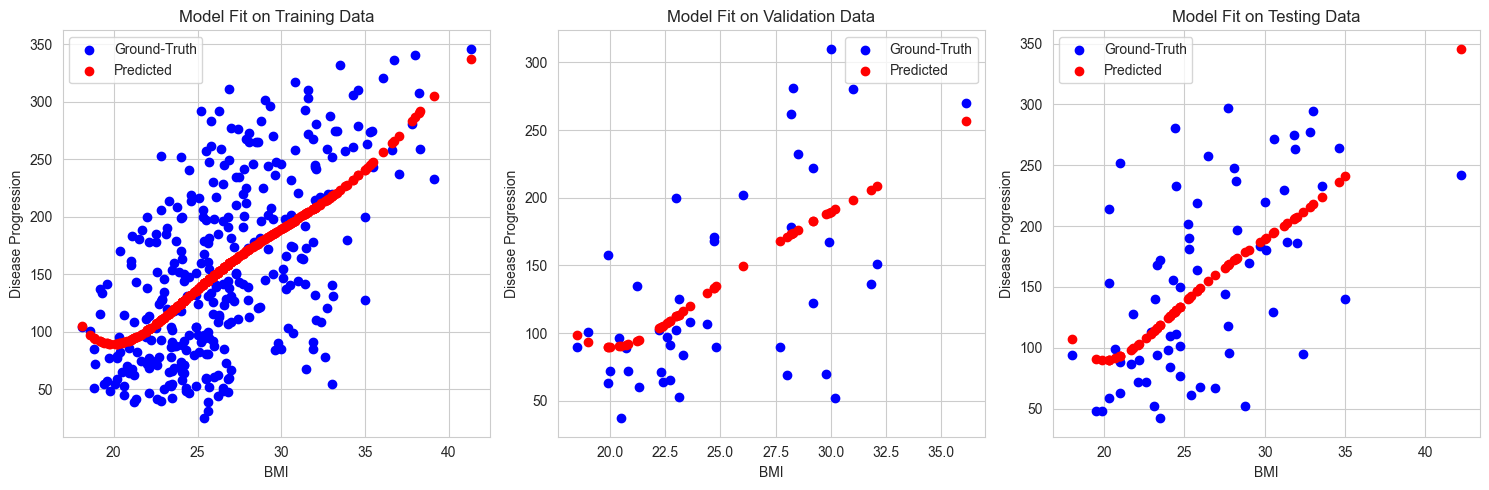

In [180]:
# Create a figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Data for each set
datasets = [
    (_X_train, y_train, 'Training Data'),
    (_X_valid, y_valid, 'Validation Data'),
    (_X_test, y_test, 'Testing Data')
]

# Loop through datasets and axes
for ax, (X, y, title) in zip(axes, datasets):
    y_pred = best_pipiline.predict(X)
    ax.scatter(X.values, y, color='blue', label='Ground-Truth')
    ax.scatter(X.values, y_pred, color='red', label='Predicted')
    ax.set_title(f'Model Fit on {title}')
    ax.set_xlabel('BMI')
    ax.set_ylabel('Disease Progression')
    ax.legend()

plt.tight_layout()
plt.show()


In [102]:
df_merged.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


### Conclusion for part-2
Unit polynomial funciton is not enough for this regression target no matter how large is the degree, because an unique bmi value can maps to different values in the dataset. Thus we need multivariate polynomial fucntion, which takes features from other important factors such as bp or s5.  
We take bmi 30 as an example shown bellow, the value can maps to 4 different labels, such as 310.0, 246.0, 85.0 and 220.0. But if we limit s5 to 5.3845, theres only 1 dependent value 310.0.

In [114]:
# Print all possible data with bmt=30
print(df_merged[df_merged["bmi"]==30]['labels'].count())
display(df_merged[df_merged["bmi"]==30])

# Print all possible data with bmt=30 and s5=5.3845
s5_value = 5.3845
print(df_merged[(df_merged["bmi"]==30) & (df_merged["s5"]==s5_value)]['labels'].count())
display(df_merged[(df_merged["bmi"]==30) & (df_merged["s5"]==s5_value)])

4


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
9,29.0,1.0,30.0,85.0,180.0,93.4,43.0,4.00,5.3845,88.0,310.0
234,61.0,1.0,30.0,108.0,194.0,100.0,52.0,3.73,5.3471,105.0,246.0
295,34.0,2.0,30.0,83.0,185.0,107.2,53.0,3.00,4.8203,92.0,85.0
440,36.0,1.0,30.0,95.0,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


1


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,labels
9,29.0,1.0,30.0,85.0,180.0,93.4,43.0,4.0,5.3845,88.0,310.0


## Part 3

### Multivariate polynomial model

#### 1. Learning with all independent variables.

In [182]:
selected_cols = X_train.columns # all columns
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = [] # Store the evaluation results for each model
pipelines = [] # Store the models and polynomial featuers

# Train and test the six models (degree 0~5)
for degree in range(6):
    # Create a pipeline with poly and model
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])

    # Training
    pipeline.fit(_X_train, y_train)
    pipelines.append(pipeline)

    # Evaluate on training set
    y_train_pred = pipeline.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = pipeline.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)

    # Number of trainable parameters
    feature_names = pipeline['poly'].get_feature_names_out()#input_features=['BMI'])
    params_nums = len(feature_names)

    # Storing results
    results.append({
        'degree': degree,
        'R_squared_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R_squared_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va,
        'Num_of_params': params_nums
    })
    
# Display the result table
results_df = pd.DataFrame(results)
display(results_df)

# Choose the best model
best_model_index = np.argmax([r['R_squared_valid'] for r in results])  # Based on R-squared
best_model_degree = results[best_model_index]['degree']
print(f"The best model-degree is: {best_model_degree}")

# Print the best model's equation
best_pipiline = pipelines[best_model_index]
best_model = best_pipiline['model']
coefficients = best_model.coef_
intercept = best_model.intercept_
feature_names = best_pipiline['poly'].get_feature_names_out()
equation = " + ".join(f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names) if coeff != 0)
print(f"The equation of the best model is: y = {intercept:.4f} + {equation}")

# Evaluate the model with testing data
y_test_pred = best_pipiline.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


,degree,R_squared_train,MAE_train,MAPE_train,R_squared_valid,MAE_valid,MAPE_va,Num_of_params
0,0,0.000000,6.620164e+01,6.282667e+01,-0.106957,66.057059,71.263880,1
1,1,0.519034,4.405480e+01,3.937052e+01,0.384874,41.830151,40.952900,11
2,2,0.469463,4.520924e+01,3.985610e+01,0.220748,47.873989,47.436124,66
3,3,0.781593,2.937647e+01,2.647344e+01,-47.946755,236.030609,224.441089,286
4,4,1.000000,2.205532e-09,1.882872e-09,-120.456537,488.306214,459.699880,1001
5,5,1.000000,1.030401e-09,8.391329e-10,-551.387525,616.456116,492.664234,3003


The best model-degree is: 1
The equation of the best model is: y = -317.5287 + 0.1735*age + -23.0670*sex + 5.7336*bmi + 1.3137*bp + -1.2638*s1 + 0.7958*s2 + 0.4306*s3 + 9.9446*s4 + 63.4271*s5 + 0.1090*s6
Testing set evaluation is: R^2: 0.524, MAE: 41.36, MAPE: 34.92%


1. When using all variables, the best model-degree is 1, acheives R^2 score 0.524 in testing set, which improves 96% of performance comparing with univariate polynomial regression.
2. While increasing the degree over 1, the overfitting proglem becomes serious, thus the best degree is degree-1.

#### 2. Learning with a few independent variables: ['bmi', 's5', 'bp'].

In [189]:
selected_cols = ['bmi', 's5', 'bp']
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = [] # Store the evaluation results for each model
pipelines = [] # Store the models and polynomial featuers

# Train and test the six models (degree 0~5)
for degree in range(6):
    # Create a pipeline with poly and model
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])

    # Training
    pipeline.fit(_X_train, y_train)
    pipelines.append(pipeline)

    # Evaluate on training set
    y_train_pred = pipeline.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = pipeline.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)

    # Number of trainable parameters
    feature_names = pipeline['poly'].get_feature_names_out()#input_features=['BMI'])
    params_nums = len(feature_names)

    # Storing results
    results.append({
        'degree': degree,
        'R_squared_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R_squared_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va,
        'Num_of_params': params_nums
    })
    
# Display the result table
results_df = pd.DataFrame(results)
display(results_df)

# Choose the best model
best_model_index = np.argmax([r['R_squared_valid'] for r in results])  # Based on R-squared
best_model_degree = results[best_model_index]['degree']
print(f"The best model-degree is: {best_model_degree}")

# Print the best model's equation
best_pipiline = pipelines[best_model_index]
best_model = best_pipiline['model']
coefficients = best_model.coef_
intercept = best_model.intercept_
feature_names = best_pipiline['poly'].get_feature_names_out()
equation = " + ".join(f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names) if coeff != 0)
print(f"The equation of the best model is: y = {intercept:.4f} + {equation}")

# Evaluate the model with testing data
y_test_pred = best_pipiline.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


,degree,R_squared_train,MAE_train,MAPE_train,R_squared_valid,MAE_valid,MAPE_va,Num_of_params
0,0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880,1
1,1,0.468843,47.163228,42.256639,0.437486,40.858872,40.105858,4
2,2,0.483629,46.394318,41.109468,0.461941,39.801976,38.763415,10
3,3,0.498852,45.488982,40.076802,0.503707,37.443323,37.385180,20
4,4,0.510780,44.773943,39.309116,0.464139,39.690153,39.511314,35
5,5,0.551657,41.980525,36.699669,0.256234,48.100496,48.018185,56


The best model-degree is: 3
The equation of the best model is: y = 3043.8828 + -120.7203*bmi + -1433.2885*s5 + 5.8281*bp + 0.2169*bmi^2 + 28.6855*bmi s5 + 0.9812*bmi bp + 237.0171*s5^2 + 0.0355*s5 bp + -0.2113*bp^2 + 0.0319*bmi^3 + -0.5231*bmi^2 s5 + -0.0025*bmi^2 bp + 1.2693*bmi s5^2 + -0.1363*bmi s5 bp + -0.0006*bmi bp^2 + -21.7869*s5^3 + 0.3499*s5^2 bp + 0.0043*s5 bp^2 + 0.0007*bp^3
Testing set evaluation is: R^2: 0.534, MAE: 42.57, MAPE: 36.24%


1. When using three variables `['bmi', 's5', 'bp']`, the best model-degree is 3, acheives R^2 score 0.534 in testing set, which improves 100% of performance comparing with univariate polynomial regression.
2. While increasing the degree over 3, the overfitting proglem becomes serious, thus the best degree is degree-3.
3. The overfitting problem is better than using all variables, this is because our dataset is not big enough to train from a large dimension of features. And when selecting featue, it's better to choose those with higher correlation to the label value. 

Based on the result:
1. Model degree-1 has the best R-squared value on validation set, it includes 6 trainable parameters.
2. The Equation is: $y = -317.53 + 0.17*age + -23.07*sex + 5.73*bmi + 1.31*bp + -1.26*s1 + 0.80*s2 + 0.43*s3 + 9.94*s4 + 63.43*s5 + 0.11*s6$
3. It shows that increasing the degree doesn't always improves the r-squared value in this multivariate model.
4. This may caused by too much dimension but only a little of data, the data are not enough for model too learn. 

###  Decision trees

#### 1. Learning with all independent variables.

   depth  R_squared_train  MAE_train  MAPE_train  R_squared_valid  MAE_valid  \
0      2         0.438054  47.996013   42.480887         0.308988  45.801381   
1      3         0.509503  44.259855   38.866592         0.198306  48.126248   
2      4         0.582718  39.815745   35.304051         0.135616  49.959975   
3      5         0.686693  33.527028   29.973625         0.093919  49.645483   
4      6         0.768015  27.090226   24.903839         0.041672  53.123174   
5      7         0.835427  21.593843   19.701590        -0.267060  60.970943   
6      8         0.887485  16.170979   15.208071        -0.271404  58.410320   
7      9         0.930804  10.942079   10.839348        -0.327677  60.408333   

     MAPE_va  
0  47.609065  
1  47.672897  
2  48.899421  
3  48.161981  
4  50.370046  
5  56.358390  
6  56.110883  
7  56.152932  
The best model-depth is: 2


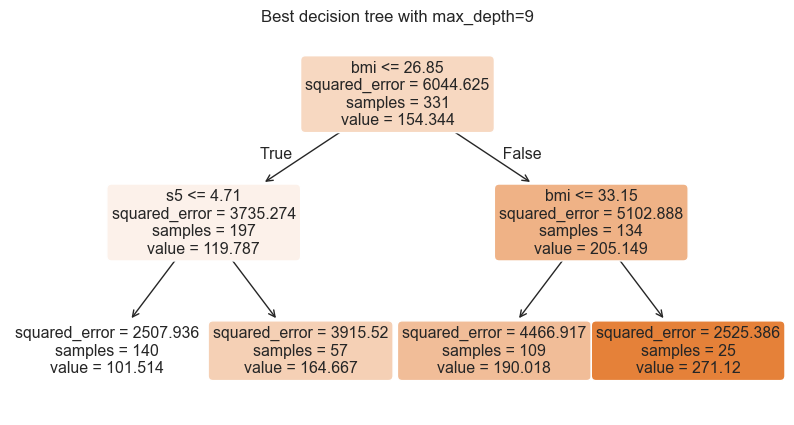

Testing set evaluation is: R^2: 0.362, MAE: 48.34, MAPE: 41.86%


In [ ]:
selected_cols = X_train.columns # all columns
_X_train = X_train
_X_valid = X_valid
_X_test = X_test

results = []
models = []
depths = []

for depth in range(2, 10):
    # Create Model
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)

    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)

    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)

    results.append({
        'depth': depth,
        'R_squared_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R_squared_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R_squared_valid'] for r in results])
best_model_depth = results[best_model_index]['depth']
best_model = models[best_model_index]
print(f"The best model-depth is: {best_model_depth}")

# Plot the best tree
fig = plt.subplots(figsize=(10, 5))
plot_tree(best_model, filled=True, feature_names=_X_test.columns, rounded=True)
plt.title(f"Best decision tree with max_depth={depth}")
plt.show()

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


Observation:
1. The model become overfiting when depth over than 3.
2. Since, the dataset is not big enough, 10 features might be too much. 

#### 2. Learning with a few independent variables.

   depth  R_squared_train  MAE_train  MAPE_train  R_squared_valid  MAE_valid  \
0      2         0.438054  47.996013   42.480887         0.308988  45.801381   
1      3         0.499399  44.772746   39.182601         0.335797  43.753465   
2      4         0.553228  41.567909   36.275771         0.369672  41.652870   
3      5         0.615865  37.457356   32.232664         0.373934  43.342610   
4      6         0.678024  33.049936   28.104516         0.289325  47.699200   
5      7         0.735824  27.194263   22.898809         0.030972  53.874783   
6      8         0.785651  23.016085   19.268672         0.005196  54.486605   
7      9         0.855797  17.123986   14.350085        -0.000734  55.219354   

     MAPE_va  
0  47.609065  
1  43.883192  
2  42.582130  
3  44.258703  
4  47.641130  
5  53.927270  
6  51.920000  
7  51.904502  
The best model-depth is: 5


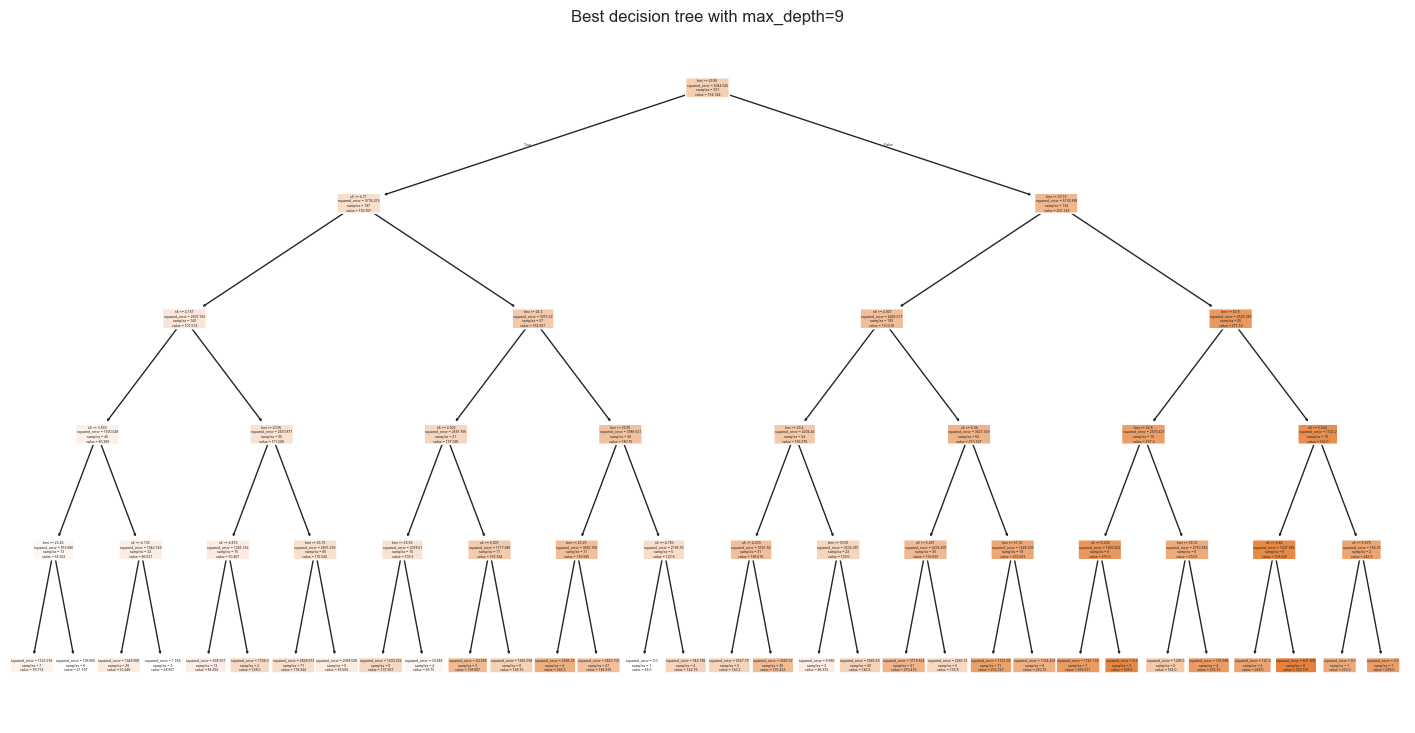

Testing set evaluation is: R^2: 0.449, MAE: 46.21, MAPE: 39.72%


In [247]:
selected_cols = ['bmi', 's5'] #, 'bp']
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []
depths = []

for depth in range(2, 10):
    # Create Model
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)

    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)

    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)

    results.append({
        'depth': depth,
        'R_squared_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R_squared_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R_squared_valid'] for r in results])
best_model_depth = results[best_model_index]['depth']
best_model = models[best_model_index]
print(f"The best model-depth is: {best_model_depth}")

# Plot the best tree
fig = plt.subplots(figsize=(18, 9))
plot_tree(best_model, filled=True, feature_names=_X_test.columns, rounded=True)
plt.title(f"Best decision tree with max_depth={depth}")
plt.show()

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


Observation:
1. The model become overfiting when depth over than 6.
2. Rather then previous test, this time we only train model with 1 feature, the bmi, this makes model afforable to be trained and test with a deeper tree. 
3. The testing set evaluation is 0.449, improves 24% compares to the previous test.

### kNNs

#### 1. Learning with all independent variables.

In [217]:
selected_cols = X_train.columns # all columns
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []

for k in range(1, 20):
    # Create Model
    model = KNeighborsRegressor(n_neighbors=k)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)
    
    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    results.append({
        'k_value': k,
        'R^2_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R^2_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R^2_valid'] for r in results])
best_k = results[best_model_index]['k_value']
best_model = models[best_model_index]
print(f"The best model is KNN with k = {best_k}")

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")


    k_value  R^2_train  MAE_train  MAPE_train  R^2_valid  MAE_valid    MAPE_va
0         1   1.000000   0.000000    0.000000  -0.614447  72.590909  66.589251
1         2   0.682213  35.037764   29.052319  -0.497869  68.693182  65.112235
2         3   0.549618  41.957704   36.084057  -0.099842  58.212121  56.323103
3         4   0.490014  44.895770   38.309235   0.021432  55.857955  52.678730
4         5   0.473082  45.790332   39.181443  -0.000485  55.300000  53.547680
5         6   0.462575  46.360524   40.036992   0.129020  50.261364  49.162529
6         7   0.436645  47.731549   41.197469   0.133626  50.327922  48.455028
7         8   0.421184  48.473565   41.991941   0.235458  48.039773  47.113019
8         9   0.430554  48.339040   41.984774   0.235618  48.621212  48.031569
9        10   0.408854  48.936858   42.573951   0.228006  49.509091  48.963058
10       11   0.410259  48.933260   43.187938   0.235641  49.495868  48.479487
11       12   0.396828  49.421450   43.654367   0.24

When running KNN regression using all features, `k=17` gives the best model, the R-square of testing set is 0.311. 

#### 2. Learn from the four features with highest correlation to the label  
According the the correlation map, we select ['bmi', 'bp', 's5', 's4'] for KNN

In [239]:
selected_cols = ['bmi', 'bp', 's5', 's4']
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []

for k in range(1, 20):
    # Create Model
    model = KNeighborsRegressor(n_neighbors=k)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)
    
    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    results.append({
        'k_value': k,
        'R^2_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R^2_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R^2_valid'] for r in results])
best_k = results[best_model_index]['k_value']
best_model = models[best_model_index]
print(f"The best model is KNN with k = {best_k}")

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")

    k_value  R^2_train  MAE_train  MAPE_train  R^2_valid  MAE_valid    MAPE_va
0         1   1.000000   0.000000    0.000000  -0.459144  67.386364  64.012816
1         2   0.705941  33.522659   28.770826  -0.124821  56.647727  55.915938
2         3   0.607541  39.251762   34.212997   0.115394  51.590909  51.775566
3         4   0.546447  42.688822   37.244710   0.271203  47.414773  48.775262
4         5   0.503415  44.441088   39.256395   0.294162  47.663636  47.287852
5         6   0.484456  46.123867   41.266018   0.303275  47.500000  46.436785
6         7   0.460696  47.169616   42.211652   0.293764  46.668831  46.246789
7         8   0.442604  47.571752   42.874161   0.320129  45.267045  44.338631
8         9   0.447269  47.080228   42.772346   0.294120  46.199495  45.747737
9        10   0.444794  47.442296   43.216348   0.245966  48.018182  47.797140
10       11   0.443353  47.846471   43.395749   0.265515  46.847107  47.057083
11       12   0.438556  47.993454   43.543387   0.28

This way the performance are better than using all features.

#### 3. Learning with one independent variables, the `bmi` which has the highest correlation to the label.

In [226]:
selected_cols = ['bmi']
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []

for k in range(1, 20):
    # Create Model
    model = KNeighborsRegressor(n_neighbors=k)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)
    
    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    results.append({
        'k_value': k,
        'R^2_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R^2_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R^2_valid'] for r in results])
best_k = results[best_model_index]['k_value']
best_model = models[best_model_index]
print(f"The best model is KNN with k = {best_k}")

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")



    k_value  R^2_train  MAE_train  MAPE_train  R^2_valid  MAE_valid    MAPE_va
0         1   0.225104  41.755287   40.685731   0.025220  55.000000  51.807652
1         2   0.487749  44.173716   40.525708   0.192526  50.090909  48.860767
2         3   0.509615  44.020141   40.082418   0.299682  45.833333  45.983291
3         4   0.508695  45.454683   40.876322   0.338695  42.198864  42.467997
4         5   0.488932  46.387915   40.967958   0.340305  43.209091  42.871488
5         6   0.471654  47.307150   42.265283   0.376337  41.261364  41.816554
6         7   0.448223  48.466120   43.135204   0.333405  43.295455  44.005419
7         8   0.437899  48.669562   44.105074   0.301183  44.744318  45.296888
8         9   0.440152  48.591809   43.606990   0.285492  45.611111  45.981946
9        10   0.418258  49.159215   44.080130   0.327695  45.015909  45.772129
10       11   0.418427  49.251305   44.274219   0.300225  46.801653  47.453264
11       12   0.412810  49.344159   44.099573   0.32

When running KNN regression with only `bmi` feature, `k = 6` gives the best result, but the testing set evaluation is still bad, the R-square is 0.164 on the testing set. This means that only one feature is not enough to predict the label by KNN. 

#### 4. How do we find the best feature-set for KNN?

##### 4.1 Pick up the 4 greatest features, by `forwarding from empty set`. 

In [240]:
knn = KNeighborsRegressor(n_neighbors=5) # Assume k = 5

# Create feature selector
sfs = SequentialFeatureSelector(knn, n_features_to_select=4, direction='forward', scoring='r2', cv=5)
sfs.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[sfs.get_support()]
print(f"selected_features:{selected_features}")

selected_features:Index(['sex', 'bmi', 's4', 's5'], dtype='object')


In [241]:
selected_cols = selected_features
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []

for k in range(1, 20):
    # Create Model
    model = KNeighborsRegressor(n_neighbors=k)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)
    
    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    results.append({
        'k_value': k,
        'R^2_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R^2_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R^2_valid'] for r in results])
best_k = results[best_model_index]['k_value']
best_model = models[best_model_index]
print(f"The best model is KNN with k = {best_k}")

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")



    k_value  R^2_train  MAE_train  MAPE_train  R^2_valid  MAE_valid    MAPE_va
0         1   0.991117   0.667674    0.805639   0.038932  51.500000  48.514771
1         2   0.731987  32.276435   27.115380   0.174785  50.625000  50.922153
2         3   0.628458  38.017120   32.293466   0.265738  46.659091  50.523714
3         4   0.569625  41.419940   35.677432   0.352059  45.659091  48.501180
4         5   0.550369  42.377039   36.463289   0.392310  43.409091  45.998399
5         6   0.534662  43.291541   37.101903   0.392595  43.087121  45.911725
6         7   0.519527  44.273198   37.984107   0.388434  42.746753  46.119928
7         8   0.512478  44.362538   38.000527   0.391169  42.997159  45.669529
8         9   0.506677  44.708627   38.600767   0.401482  43.136364  45.290298
9        10   0.500380  45.203021   39.185317   0.426790  41.659091  43.543044
10       11   0.492929  45.540236   39.380747   0.435893  41.051653  43.060928
11       12   0.488480  45.626133   39.450799   0.45

The best model is KNN with k=12, the R-square of testing set impoves to 0.426. The result is better than just using four highest correlation features ['bmi', 'bp', 's5', 's4'] which has a R-suared value of 0.376.

##### 5.2 Pick up the 4 greatest features, by `backwarding from full set`. 

In [236]:
knn = KNeighborsRegressor(n_neighbors=5) # Assume k = 5

# Create feature selector
sfs = SequentialFeatureSelector(knn, n_features_to_select=4, direction='backward', scoring='r2', cv=5)
sfs.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[sfs.get_support()]
print(f"selected_features:{selected_features}")

selected_features:Index(['age', 'bmi', 'bp', 's6'], dtype='object')


In [237]:
selected_cols = selected_features
_X_train = X_train[selected_cols]
_X_valid = X_valid[selected_cols]
_X_test = X_test[selected_cols]

results = []
models = []

for k in range(1, 20):
    # Create Model
    model = KNeighborsRegressor(n_neighbors=k)

    # Training
    model.fit(_X_train, y_train)
    models.append(model)
    
    # Evaluate on training set
    y_train_pred = model.predict(_X_train)
    mae_tr = mean_absolute_error(y_train, y_train_pred)
    mape_tr = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    r_squared_tr = r2_score(y_train, y_train_pred)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(_X_valid)
    mae_va = mean_absolute_error(y_valid, y_valid_pred)
    mape_va = np.mean(np.abs((y_valid - y_valid_pred) / y_valid)) * 100
    r_squared_va = r2_score(y_valid, y_valid_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    results.append({
        'k_value': k,
        'R^2_train': r_squared_tr,
        'MAE_train': mae_tr,
        'MAPE_train': mape_tr,
        'R^2_valid': r_squared_va,
        'MAE_valid': mae_va,
        'MAPE_va': mape_va
    })

# Display the result table
results_df = pd.DataFrame(results)
print(results_df)

# Choose the best model
best_model_index = np.argmax([r['R^2_valid'] for r in results])
best_k = results[best_model_index]['k_value']
best_model = models[best_model_index]
print(f"The best model is KNN with k = {best_k}")

# Evaluate the model with testing data
y_test_pred = best_model.predict(_X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r_squared = r2_score(y_test, y_test_pred)
print(f"Testing set evaluation is: R^2: {test_r_squared:.3f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")



    k_value  R^2_train  MAE_train  MAPE_train  R^2_valid  MAE_valid    MAPE_va
0         1   1.000000   0.000000    0.000000  -0.293706  62.636364  61.543935
1         2   0.703951  34.324773   30.630207   0.058621  53.250000  53.819787
2         3   0.616340  37.981873   33.323852   0.099065  52.969697  51.351765
3         4   0.589329  40.090634   36.100583   0.202942  49.335227  45.303916
4         5   0.535610  42.465257   37.908499   0.260597  48.809091  45.759265
5         6   0.512921  43.804129   39.347722   0.282187  49.348485  47.135469
6         7   0.491120  45.143289   41.153508   0.290168  48.032468  46.113886
7         8   0.457700  47.136329   42.608118   0.341594  48.017045  46.221675
8         9   0.445135  47.734475   43.145079   0.326600  48.007576  46.870012
9        10   0.433767  48.354079   43.887118   0.315233  47.979545  46.885630
10       11   0.414847  49.413897   44.863430   0.341929  46.252066  45.619660
11       12   0.403182  49.939829   45.266320   0.32

The best model is KNN with k=11, the R-square of testing set is 0.228.

### Conclusion for Part-3
1. For polynomial model, we have tried choosing all features or just a few features like (bmi, s5, bp), and we found using less features might have better performance and decrease the possible of overfitting. 
2. For decision tree, the phenomenan is similar, dopping some features is better than choosing all the features.
3. For KNN, fewer features are also greater than using all features. But we met a problem of how to select the features? Can we just pick the 4 features which has higher correlation with the label? Finally, we found that we can add a preprocessing step as well as forwardingly select features with SequentialFeatureSelector(), this can help us choose the best features for KNN.

## Summary

1. Multivariate polynomial model is the best way to predict the risk of diabetes progression in this dataset.  
2. One feature is not enough for model to learn patterns and predict the labels. We need multivariate for all types of approach, like polynomial regression, decision tree and kNN.
3. Because our dataset is not large enough, it will be difficult to train the model using all features. Thus, in part3 we should only pick a few features for training and testing.
4. The overfitting problem can occurs when increasing the degree of a polynolial model or the depth of a decision tree.
5. The perfact way of selecting best feature-set for model is not like only choose the features which are highly correlated to the labels, we can select them by doing cross-validation test with our training data, and choose the best set.  

## Questions (or Todo list)
1. What's the perfect way of selecting the greatest feature-set? Can we consider it from the correlation heat map?
2. What does the gender maps to the value in sex column? We haven'nt find the description from the dataset.
3. Is there anyother data that can be filtered out to improve the model? (Except outliers)